In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import h3
from shapely.geometry import shape, Polygon
import shapely
import folium
import json
import math


In [3]:
trips = pd.read_parquet('../00_data/processed/trips.parquet')
trips_g =pd.read_parquet('../00_data/processed/trips_grouped_spatio_temporal.parquet')
weather = pd.read_parquet('../00_data/repo_data/weather_aggr.parquet')
relocations = pd.read_parquet('../00_data/processed/relocations.parquet')
landuse = pd.read_parquet('../00_data/repo_data/hexagons_land_use_columns.parquet')
tripuse = pd.read_parquet('../00_data/repo_data/trips_land_use.parquet')
pois = pd.read_parquet('../00_data/processed/hexagons_with_pois.parquet')
file = "../00_data/repo_data/DE008L2_LEIPZIG_UA2018_v013/Data/DE008L2_LEIPZIG_UA2018_v013.gpkg"
land_usepolys = gpd.read_file(file)
availability = pd.read_parquet('../00_data/processed/availability.parquet')

# Relationships Between Trips And Other Influencing Factors
This notebook deals with the descritive analysis of trip data in relationship to other influencing factors like weather, land use and points of interest. First we look at the demand in dependance on temperature. First in the absolute amount of trips and second accounting for the actual distribution of days with a given temperature.

In [4]:

trips['datetime_h'] = trips['datetime_start'].dt.round('H')


In [5]:
tripweather = pd.merge(trips, weather, how='left', left_on ='datetime_h', right_on= 'MESS_DATUM')


In [6]:
tripweather["mintemp_r"] = tripweather["min_temperature"].round(1)
tripweather["meantemp_r"] = tripweather["mean_temperature"].round(1)
tripweather["maxtemp_r"] = tripweather["max_temperature"].round(1)

,count,metric,temp %,cleaned_count
temperature °C,,,,
-10.4,12,min_temp,0.000267,44895.0
-10.2,4,min_temp,0.000134,29930.0
-10.1,3,min_temp,0.000067,44895.0
-9.7,8,min_temp,0.000134,59860.0
-9.4,4,min_temp,0.000067,59860.0
...,...,...,...,...
36.2,239,max_temp,0.000134,1788317.5
36.4,123,max_temp,0.000067,1840695.0
37.0,113,max_temp,0.000067,1691045.0


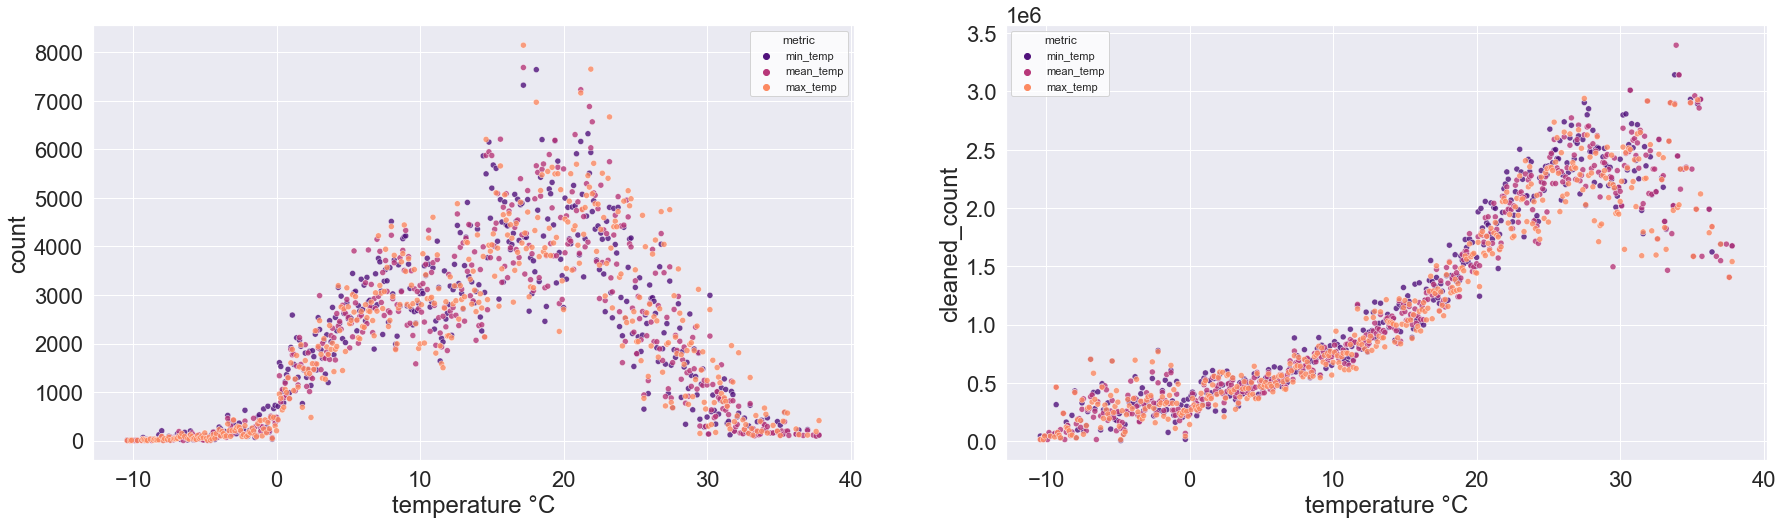

In [7]:
sns.set(font_scale = 2)
f,ax = plt.subplots(1,2,figsize=(30,8))
sns.set(style="whitegrid")
meanperc = (weather["mean_temperature"].round(1).value_counts()/weather["mean_temperature"].size).rename("temp %")
minperc = (weather["min_temperature"].round(1).value_counts()/weather["min_temperature"].size).rename("temp %")
maxperc = (weather["max_temperature"].round(1).value_counts()/weather["max_temperature"].size).rename("temp %")
y1 = tripweather.groupby(['mintemp_r']).size().to_frame("count")
y1["metric"] = "min_temp"
y1 = y1.merge(minperc, left_index=True, right_index=True)
y2 = tripweather.groupby(['meantemp_r']).size().to_frame("count")
y2["metric"] = "mean_temp"
y2 = y2.merge(meanperc, left_index=True, right_index=True)    
y3 = tripweather.groupby(['maxtemp_r']).size().to_frame("count")
y3["metric"] = "max_temp"
y3 = y3.merge(maxperc, left_index=True, right_index=True)
y_all = pd.concat([y1, y2, y3])
y_all.index.rename("temperature °C", inplace=True)
y_all["cleaned_count"] = y_all["count"]/y_all["temp %"]
sns.scatterplot(data = y_all, x = y_all.index, y ="count", hue ="metric", palette = "magma", alpha = 0.8, ax = ax[0])
sns.scatterplot(data = y_all, x = y_all.index, y ="cleaned_count", hue ="metric", palette = "magma", alpha = 0.8, ax = ax[1])

weather["mean_temperature"].mean()
y_all


We can see that relative demand rises with higher temperature until it plateaus at about 30° C

We do the same for the mean windspeed

2.378829908675799

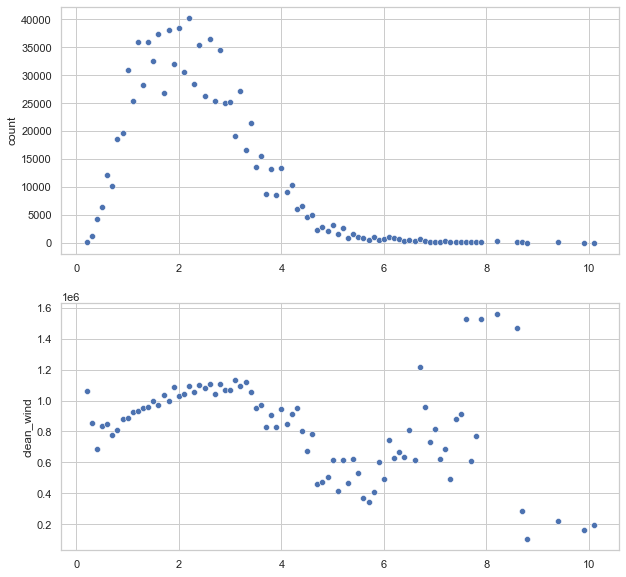

In [8]:
f, ax = plt.subplots(2,1, figsize=(10, 10))
tripweather["mean_mean_wind_speed_r"] = tripweather["mean_mean_wind_speed"].round(1)
y = tripweather.groupby(['mean_mean_wind_speed_r']).size().to_frame("count")
windperc = (weather["mean_mean_wind_speed"].round(1).value_counts()/weather["mean_mean_wind_speed"].size).rename("wind %")
y = y.merge(windperc, left_index=True, right_index=True)
y["clean_wind"] = y["count"]/y["wind %"]
sns.scatterplot(data = y, x = y.index, y ="count", palette = "magma", ax = ax[0])
sns.scatterplot(data = y, x = y.index, y ="clean_wind", palette = "magma", ax = ax[1])
weather["mean_mean_wind_speed"].mean()



We can see that demand declines between 2 and 6. After that the graph gets really noise which is probably due to the lack of observations with windspeeds that high

We also look at the demand at different values of the mean total cloud cover

<AxesSubplot:ylabel='cleaned_count'>

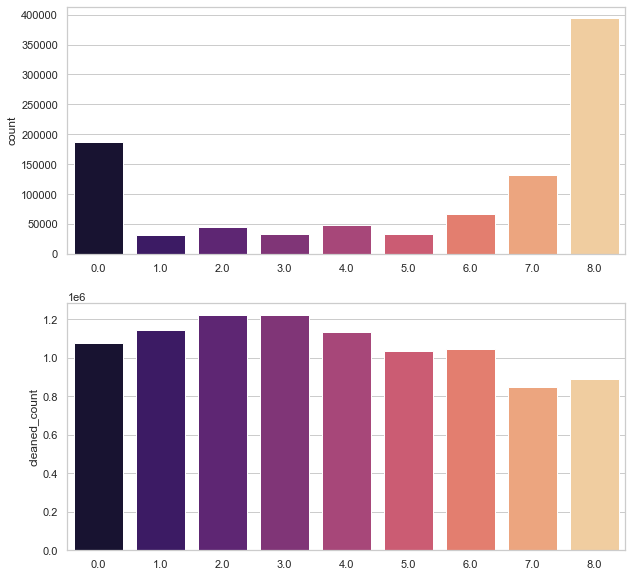

In [9]:
f, ax = plt.subplots(2,1, figsize=(10, 10))
tripweather["mean_total_cloud_cover_r"] = tripweather["mean_total_cloud_cover"].round(0)
y = tripweather.groupby(['mean_total_cloud_cover_r']).size().to_frame("count")
coverageperc = (weather["mean_total_cloud_cover"].round(0).value_counts()/weather["mean_total_cloud_cover"].size).rename("coverage %")
y = y.merge(coverageperc, left_index=True, right_index=True)
y["cleaned_count"] = y["count"] / y["coverage %"]
sns.barplot(data = y, x = y.index, y ="count", palette = "magma", ax = ax [0])
sns.barplot(data = y, x = y.index, y ="cleaned_count", palette = "magma", ax = ax[1])



We load in the flexzone, the zone in which nextbikes can be left, of so we can evaluate the ratio of landuses inside it for later analysis

In [10]:
import sys, os
import tarfile
import os
sys.path.append(os.path.abspath('..'))
%load_ext autoreload
%autoreload 2

from modules.config import *
tarfile_path = TRIPS_TARFILE_PATH
unpacked_path = UNPACKED_TRIPS_DIR_PATH

# Unpack
with tarfile.open(tarfile_path, 'r') as tar:
	tar.extractall(DATA_DIR_PATH)
# find all csv files in the unpacked directory
csv_files = []

def get_csv_files_recursively(path):
	for file in os.listdir(path):
		if os.path.isdir(os.path.join(path, file)):
			get_csv_files_recursively(os.path.join(path, file))
		elif file.endswith(".csv"):
			csv_files.append(os.path.join(path, file))

get_csv_files_recursively(unpacked_path)

csv_files[:5]

['b:\\Github desktop Repos\\aaa-2022-magma\\00_data\\leipzig\\2019\\01\\positions_nextbike_leipzig_2019_01_20.csv',
 'b:\\Github desktop Repos\\aaa-2022-magma\\00_data\\leipzig\\2019\\01\\positions_nextbike_leipzig_2019_01_21.csv',
 'b:\\Github desktop Repos\\aaa-2022-magma\\00_data\\leipzig\\2019\\01\\positions_nextbike_leipzig_2019_01_22.csv',
 'b:\\Github desktop Repos\\aaa-2022-magma\\00_data\\leipzig\\2019\\01\\positions_nextbike_leipzig_2019_01_23.csv',
 'b:\\Github desktop Repos\\aaa-2022-magma\\00_data\\leipzig\\2019\\01\\positions_nextbike_leipzig_2019_01_24.csv']

In [11]:
#read data
import shapely
flexzone = gpd.read_file(FLEXZONE_GEOJSON_PATH)
flexzone.geometry = flexzone.geometry.map(lambda polygon: shapely.ops.transform(lambda x, y: (y, x), polygon))
flexzone_loose = flexzone.dissolve()
flexzone_loose = flexzone_loose.to_crs(epsg=3763)
flexzone_loose = flexzone_loose.buffer(10000)
flexzone_loose = flexzone_loose.to_crs(epsg=4326)
flexzone_loose = gpd.GeoDataFrame(geometry=flexzone_loose)
flexzone_loose = flexzone_loose.to_crs(epsg=4326)

flexzone_size = flexzone_loose["geometry"].area
flexzone_size = flexzone_size

C:\Users\jan\AppData\Local\Temp/ipykernel_2388/2896247154.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  flexzone_size = flexzone_loose["geometry"].area


In [12]:
land_use_geo = gpd.GeoDataFrame(land_usepolys)
land_use_geo = land_use_geo.to_crs(epsg=3035)
land_use_geo = land_use_geo.to_crs(epsg=4326)
land_use_geo_reversed = land_use_geo.geometry.map(lambda multipolygon: shapely.ops.transform(lambda x, y: (y, x), multipolygon))
land_use_geo["geometry"] =  land_use_geo_reversed
land_use_geo
land_use_flexzone= gpd.overlay(land_use_geo, flexzone_loose, how='intersection')
land_use_flexzone

,country,fua_name,fua_code,code_2018,class_2018,prod_date,identifier,perimeter,area,comment,Pop2018,geometry
0,DE,Leipzig,DE008L2,11210,Discontinuous dense urban fabric (S.L. : 50% -...,2020-08,3969-DE008L2,135.628940,1080.015902,None,2,"POLYGON ((51.25573 12.37944, 51.25572 12.37906..."
1,DE,Leipzig,DE008L2,11210,Discontinuous dense urban fabric (S.L. : 50% -...,2020-08,5569-DE008L2,336.629685,6332.695900,None,92,"POLYGON ((51.32675 12.28788, 51.32606 12.28668..."
2,DE,Leipzig,DE008L2,11210,Discontinuous dense urban fabric (S.L. : 50% -...,2020-08,4352-DE008L2,3219.516723,71745.283513,None,430,"POLYGON ((51.27010 12.36293, 51.26951 12.36298..."
3,DE,Leipzig,DE008L2,12100,"Industrial, commercial, public, military and p...",2020-08,17695-DE008L2,298.224118,5453.464295,None,2,"POLYGON ((51.30811 12.43117, 51.30813 12.43117..."
4,DE,Leipzig,DE008L2,11100,Continuous urban fabric (S.L. : > 80%),2020-08,998-DE008L2,218.411702,2117.440017,None,35,"POLYGON ((51.33568 12.38648, 51.33591 12.38532..."
...,...,...,...,...,...,...,...,...,...,...,...,...
7310,DE,Leipzig,DE008L2,14200,Sports and leisure facilities,2020-08,24688-DE008L2,557.427200,15773.143591,None,1,"POLYGON ((51.39093 12.31474, 51.39170 12.31463..."
7311,DE,Leipzig,DE008L2,14200,Sports and leisure facilities,2020-08,24690-DE008L2,673.816094,26903.857103,None,1,"POLYGON ((51.39186 12.31176, 51.39179 12.31350..."
7312,DE,Leipzig,DE008L2,14200,Sports and leisure facilities,2020-08,24804-DE008L2,1221.262569,94544.717704,None,18,"POLYGON ((51.38517 12.35545, 51.38508 12.35522..."
7313,DE,Leipzig,DE008L2,14200,Sports and leisure facilities,2020-08,24830-DE008L2,1031.340083,22023.996003,None,10,"POLYGON ((51.36356 12.40752, 51.36355 12.40752..."


In [13]:
land_use_flexzone["area"] = land_use_flexzone["geometry"].area
landuseareas = land_use_flexzone.groupby(["class_2018"])["area"].sum()


C:\Users\jan\AppData\Local\Temp/ipykernel_2388/1388140728.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  land_use_flexzone["area"] = land_use_flexzone["geometry"].area


In [14]:

land_use_flexzone["area"] = land_use_flexzone["geometry"].area
landuseratio = land_use_flexzone.groupby(["class_2018"])["area"].sum().to_frame("ratio")
landuseratio = landuseratio / landuseratio.sum()
landuseratio

C:\Users\jan\AppData\Local\Temp/ipykernel_2388/1787338608.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  land_use_flexzone["area"] = land_use_flexzone["geometry"].area


,ratio
class_2018,
Arable land (annual crops),0.194186
Construction sites,0.000730
Continuous urban fabric (S.L. : > 80%),0.058784
Discontinuous dense urban fabric (S.L. : 50% - 80%),0.134772
Discontinuous low density urban fabric (S.L. : 10% - 30%),0.003165
Discontinuous medium density urban fabric (S.L. : 30% - 50%),0.032579
Discontinuous very low density urban fabric (S.L. : < 10%),0.000365
Fast transit roads and associated land,0.003868
Forests,0.059378


c:\Users\jan\miniconda3\envs\aaMagma\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


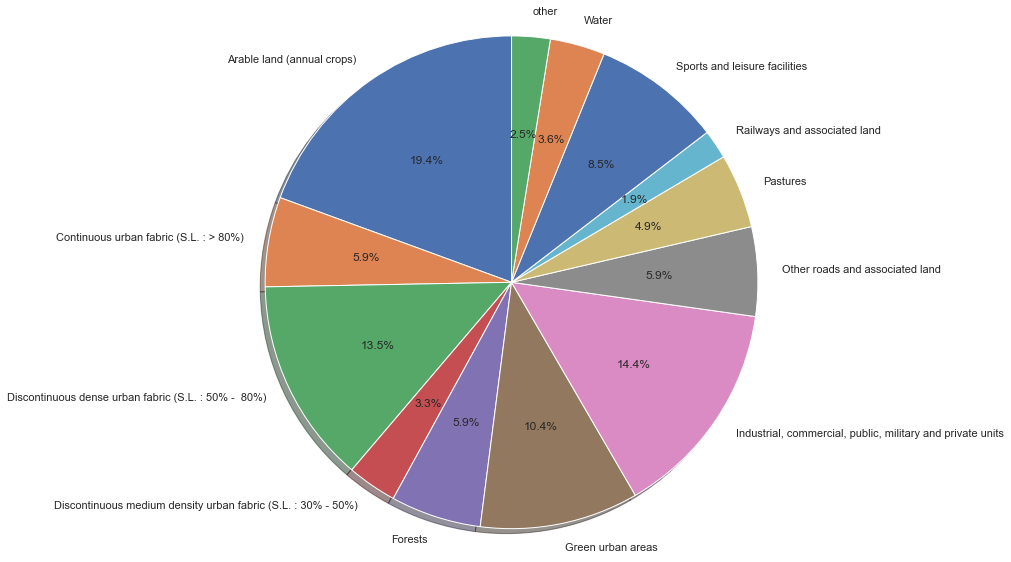

In [15]:
other = landuseratio[landuseratio["ratio"]<0.01]
othersum = other["ratio"].sum()
landuseratio_big = landuseratio[landuseratio["ratio"]>0.01]
landuseratio_big.loc["other"] = [othersum]
fig1, ax1 = plt.subplots(figsize = (15,10))

ax1.pie(landuseratio_big["ratio"], labels=landuseratio_big.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()

The next metric we analyze is land use. We first evaluate the total number of trips that start or end where a given landuse is. The second chart utilized the ratios we computed in th last section to account for distributions of landuse in the flexzone

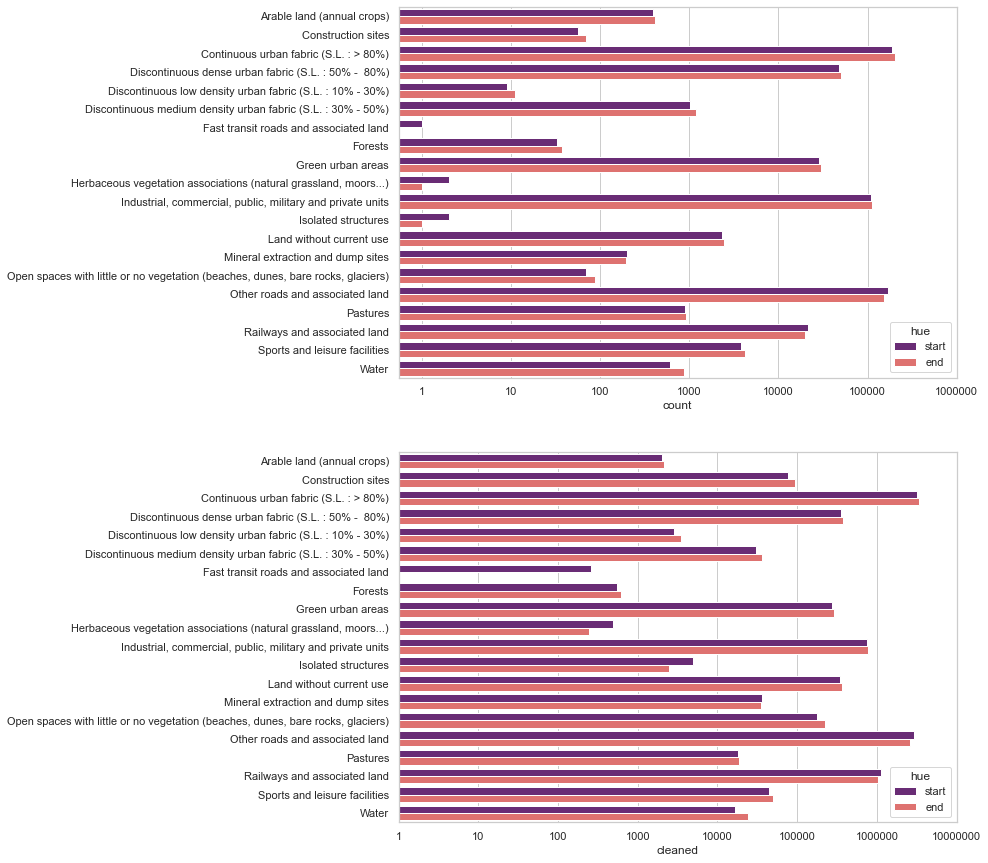

In [20]:
sns.set(style="whitegrid")
f, ax = plt.subplots(2,1 ,figsize=(10, 15))
y1 = tripuse["land_use_start"].value_counts().to_frame("count")
y1["hue"] = "start"
y2 = tripuse["land_use_end"].value_counts().to_frame("count")
y2["hue"] = "end"
y_all = pd.concat([y1, y2])
y_all = y_all.merge(landuseratio, left_index= True, right_index = True)
y_all["cleaned"] = y_all["count"]/y_all["ratio"]
g = sns.barplot(data = y_all, x = "count", y = y_all.index, hue = "hue", palette= "magma", ax = ax[0])
g.set_xscale("log")

ticks = [1, 10, 100, 1000, 10000, 100000, 1000000]
g.set_xticks(ticks)
g.set_xticklabels(ticks)
g = sns.barplot(data = y_all, x = "cleaned", y = y_all.index, hue = "hue", palette= "magma", ax=ax[1] )
#g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 22)
#g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 22)
#g.set_xlabel("Number of trips", fontsize = 22)
g.set_xscale("log")
ticks = [1, 10, 100, 1000, 10000, 100000, 1000000, 10000000]
g.set_xticks(ticks)
g.set_xticklabels(ticks)
plt.show()


Most trips start and end in "continuous urban fabric" and along "roads and associated land" this does not change when adjusted for their frequency. Also no land use appears to be significantly more often the destination rather than origin of a trip or vice versa.

In [21]:
poicategories = ['sustenance_poi',
       'public_transport_poi', 'education_poi', 'arts_and_culture_poi',
       'sports_poi']

For our analysis of points of interest we filter out the data with h3 resolution 9. Addditionally we create a second dataframe that does not count the number of POIs but takes the value 1 when a given POI exists and 0 when it doesnt.

In [22]:

pois9 = pois[pois["h3_res"] == 9]
naive_pois = pois9.copy()

for poi in poicategories:
    naive_pois[poi] = naive_pois[poi].clip(0,1)
naive_pois


trips_9 = trips_g[trips_g["h3_res"] == 9]



Similiar to our approach with the land uses we compute for pois the ratio of each category of POI compared to the total number.

In [23]:
poiratios = pd.DataFrame(index = poicategories, columns = ["ratio"])
pois9["all_pois"] = pois9.sustenance_poi + pois9.public_transport_poi + pois9.education_poi + pois9.arts_and_culture_poi + pois9.sports_poi
for poi in poicategories:
    poiratios["ratio"][poiratios.index == poi] = pois9[poi].sum() / pois9["all_pois"].sum()

poiratios

C:\Users\jan\AppData\Local\Temp/ipykernel_2388/2424669188.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pois9["all_pois"] = pois9.sustenance_poi + pois9.public_transport_poi + pois9.education_poi + pois9.arts_and_culture_poi + pois9.sports_poi


,ratio
sustenance_poi,0.459345
public_transport_poi,0.43235
education_poi,0.053068
arts_and_culture_poi,0.017292
sports_poi,0.037944


The following chart counts the number of trips that start and end adjacend to at least one POI of each given category

In [24]:

naive_pois_starts = pd.merge(trips_9, naive_pois, how='left', left_on = "start_hex_id", right_on = "hex")
naive_pois_ends = pd.merge(trips_9, naive_pois, how='left', left_on = "end_hex_id", right_on = "hex")


In [25]:
for poi in poicategories:
    naive_pois_starts[poi] = naive_pois_starts[poi] * naive_pois_starts["demand"]
    naive_pois_ends[poi] = naive_pois_ends[poi] * naive_pois_ends["demand"]

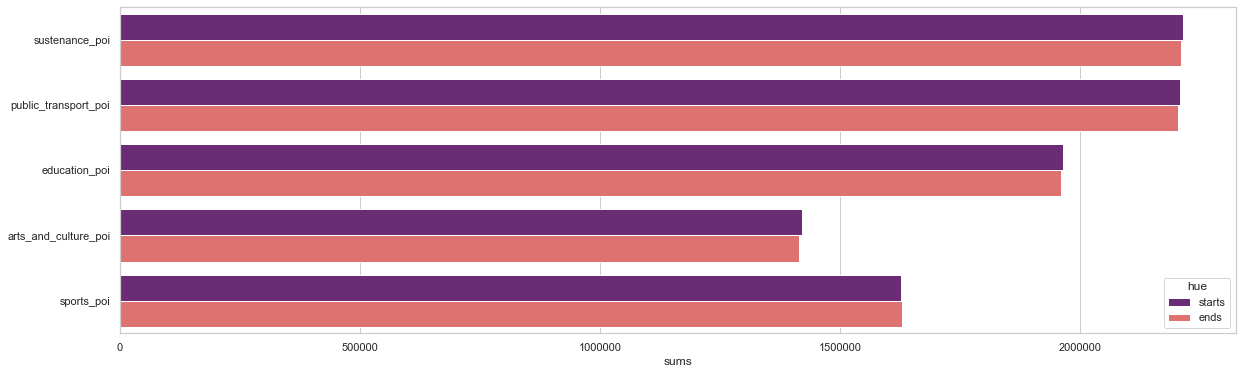

In [26]:
startssum = [
    naive_pois_starts.sustenance_poi.sum(),
    naive_pois_starts.public_transport_poi.sum(),
    naive_pois_starts.education_poi.sum(),
    naive_pois_starts.arts_and_culture_poi.sum(),
    naive_pois_starts.sports_poi.sum(),
]
endssum = [
    naive_pois_ends.sustenance_poi.sum(),
    naive_pois_ends.public_transport_poi.sum(),
    naive_pois_ends.education_poi.sum(),
    naive_pois_ends.arts_and_culture_poi.sum(),
    naive_pois_ends.sports_poi.sum()
]

startsumdf = pd.DataFrame(index = poicategories)
endsumdf = pd.DataFrame(index = poicategories)
total = pd.DataFrame(index = ["total number of trips"])
startsumdf["sums"] = startssum
startsumdf["hue"] = "starts"
endsumdf["sums"] = endssum
endsumdf["hue"] = "ends"
total["sums"] = trips_9["demand"].sum()
total["hue2"] = "total"
sumsum = pd.concat([startsumdf, endsumdf])


f, ax = plt.subplots( figsize=(20, 6))
sns.barplot(data = sumsum, x = "sums", y = sumsum.index, palette= "magma", hue= "hue", )
plt.ticklabel_format(style='plain', axis='x')

plt.show()


We can see that are not a lot of trips that do not have at leat a POI of each category in their start or end hexagons. Especially for sustenance and public transport POIs less so for arts and culture.

In [27]:
startpois9 = pd.merge(trips_9, pois9, how='left', left_on = "start_hex_id", right_on = "hex")
endpois9 = pd.merge(trips_9, pois9, how='left', left_on = "end_hex_id", right_on = "hex")
trippois9 = pd.merge(startpois9, pois9, how='left', left_on = "end_hex_id", right_on = "hex")

The next section analyzes the differences in POIs that occur between start and end of a trip. The first chart shows the average difference in POIs for trips in which there is a difference for this POI. The second chart shows the number of trips for each category of POI in which a difference in this catergory of POI occurs.

In [29]:
for poi in poicategories:
    trippois9[poi + "_diff"] = abs(trippois9[poi + "_x"] - trippois9[poi + "_y"])


poidiffs = pd.DataFrame(index = poicategories, columns = ["mean","amount_with_diff"])
sustenancetrip = trippois9[trippois9.sustenance_poi_diff != 0]
poidiffs["mean"] [poidiffs.index == "sustenance_poi"] = sustenancetrip.sustenance_poi_diff.mean()
poidiffs["amount_with_diff"] [poidiffs.index == "sustenance_poi"] = sustenancetrip.demand.sum()
publictransporttrip = trippois9[trippois9.public_transport_poi_diff != 0]
poidiffs["mean"] [poidiffs.index == "public_transport_poi"] = publictransporttrip.public_transport_poi_diff.mean()
poidiffs["amount_with_diff"] [poidiffs.index == "public_transport_poi"] = publictransporttrip.demand.sum()
educationtrip = trippois9[trippois9.education_poi_diff != 0]
poidiffs["mean"] [poidiffs.index == "education_poi"] = educationtrip.education_poi_diff.mean()
poidiffs["amount_with_diff"] [poidiffs.index == "education_poi"] = educationtrip.demand.sum()
artsandculturetrip = trippois9[trippois9.arts_and_culture_poi_diff != 0]
poidiffs["mean"] [poidiffs.index == "arts_and_culture_poi"] = artsandculturetrip.arts_and_culture_poi_diff.mean()
poidiffs["amount_with_diff"] [poidiffs.index == "arts_and_culture_poi"] = artsandculturetrip.demand.sum()
sporttrip = trippois9[trippois9.sports_poi_diff != 0]
poidiffs["mean"] [poidiffs.index == "sports_poi"] = sporttrip.sports_poi_diff.mean()
poidiffs["amount_with_diff"] [poidiffs.index == "sports_poi"] = sporttrip.demand.sum()



2301268

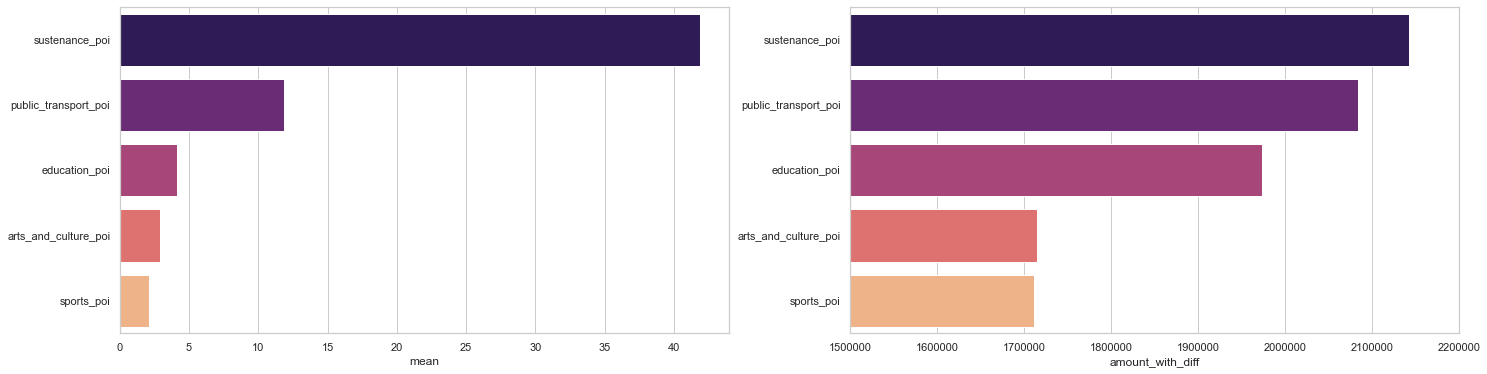

In [30]:
f, ax = plt.subplots(1,2, figsize=(24, 6))
sns.barplot(data = poidiffs, x = "mean", y = poidiffs.index, ax=ax[0], palette = "magma")
sns.barplot(data = poidiffs, x = "amount_with_diff", y = poidiffs.index, ax = ax[1], palette = "magma")
plt.xlim(1500000, 2200000)
plt.ticklabel_format(style='plain', axis='x')

trippois9.demand.sum()

We can see that difference between starts and ends happens between sustenance pois. This category also has the most trips with any difference

The next section concentrates on the last trip of each bike to potentially find landuses or POIs which are most often at the location where a bike was used for the last time

In [31]:
tripsbytime = trips.sort_values(by=["datetime_end"])
triplasts = tripsbytime.groupby("b_number").last()
triplasts.reset_index(inplace=True)
triplasts = triplasts[["b_number", "lat_end", "lng_end"]]
triplasts["hex_id"] = 0

for i in range(len(triplasts)):
    triplasts["hex_id"][triplasts.index == i] = h3.geo_to_h3(triplasts.lat_end[triplasts.index == i], triplasts.lng_end[triplasts.index == i], resolution = 9)

triplasts


C:\Users\jan\AppData\Local\Temp/ipykernel_2388/3448636401.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  triplasts["hex_id"][triplasts.index == i] = h3.geo_to_h3(triplasts.lat_end[triplasts.index == i], triplasts.lng_end[triplasts.index == i], resolution = 9)


,b_number,lat_end,lng_end,hex_id
0,10900,51.330267,12.341958,891f1a8d9a7ffff
1,20000,51.340524,12.368993,891f1a8cb53ffff
2,20001,51.348956,12.314547,891f1a8ce4bffff
3,20002,51.332169,12.395483,891f1a16513ffff
4,20004,51.359747,12.411364,891f1a8c92fffff
...,...,...,...,...
1036,99982,51.341065,12.365005,891f1a8ca27ffff
1037,99991,51.324636,12.338376,891f1a8d933ffff
1038,99993,51.324862,12.337850,891f1a8d933ffff
1039,99997,51.325276,12.337850,891f1a8d933ffff


In [32]:
lastpoi = pd.merge(triplasts, pois9, how='left', left_on = "hex_id", right_on = "hex")

lastpoisum = pd.DataFrame(index = poicategories, columns = ["sum"])
lastpoimean = pd.DataFrame(index = poicategories, columns = ["mean"])

for poi in poicategories:
    lastpoisum["sum"][lastpoisum.index == poi] = lastpoi[poi].sum()
    lastpoimean["mean"][lastpoimean.index == poi] = lastpoi[poi].mean()

lastpoisum = pd.merge(lastpoisum, poiratios, how='left', left_index = True, right_index = True)
lastpoimean = pd.merge(lastpoimean, poiratios, how='left', left_index = True, right_index = True)

lastpoisum["weigtedsum"] = lastpoisum["sum"] / lastpoisum["ratio"]
lastpoimean["weigtedmean"] = lastpoimean["mean"] / lastpoimean["ratio"]	




The following plots show the POI categories adjacent to the last hexagon each bike ended a trip in. First in absolute terms. Second compared to the frequency of different POI categories.

<AxesSubplot:xlabel='weigtedmean'>

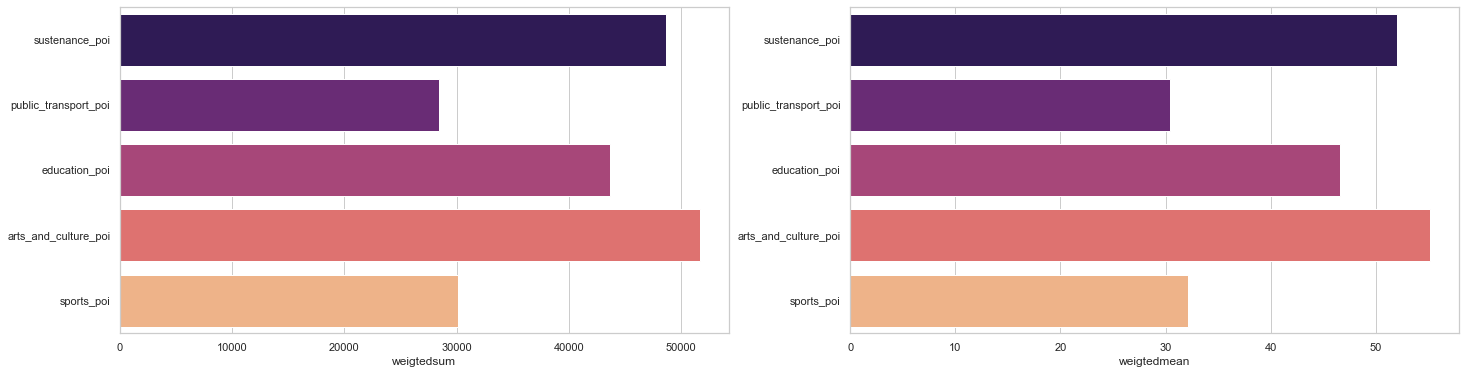

In [33]:
f, ax = plt.subplots(1,2, figsize=(24, 6))
sns.barplot(data = lastpoisum, x = "weigtedsum", y = lastpoisum.index, ax=ax[0], palette = "magma")
sns.barplot(data = lastpoimean, x = "weigtedmean", y = lastpoimean.index, ax = ax[1], palette = "magma")

In [34]:

landusejson = json.load(open('../00_data/processed/land_use_dict.json'))
landusejson = pd.DataFrame.from_dict(landusejson, orient='index', columns =["new_index"])
landusejson.reset_index(inplace=True)
landusejson.drop("new_index",axis = 1, inplace=True)

lastuse = pd.merge(triplasts, landuse, how='left', left_on = "hex_id", right_on = "hexagon_id")

lastuseweighted = lastuse.copy()



landuseratios = pd.merge(landusejson, landuseratio, how='left', left_on = "index", right_on = "class_2018")

for i in range(22):
   lastuseweighted["land_use_" + str(i+1)] = lastuse["land_use_" + str(i+1)] / landuseratios["ratio"][landuseratios.index == i].sum()

landuseratios


,index,ratio
0,Discontinuous dense urban fabric (S.L. : 50% -...,0.134772
1,"Industrial, commercial, public, military and p...",0.143961
2,Continuous urban fabric (S.L. : > 80%),0.058784
3,Sports and leisure facilities,0.084637
4,Green urban areas,0.104098
5,Discontinuous medium density urban fabric (S.L...,0.032579
6,Arable land (annual crops),0.194186
7,Pastures,0.048695
8,Land without current use,0.006746
9,Forests,0.059378


The next chart shows the frequeny that bikes end their last trip in a hexagon with each land use compared to  the frequency of the land use

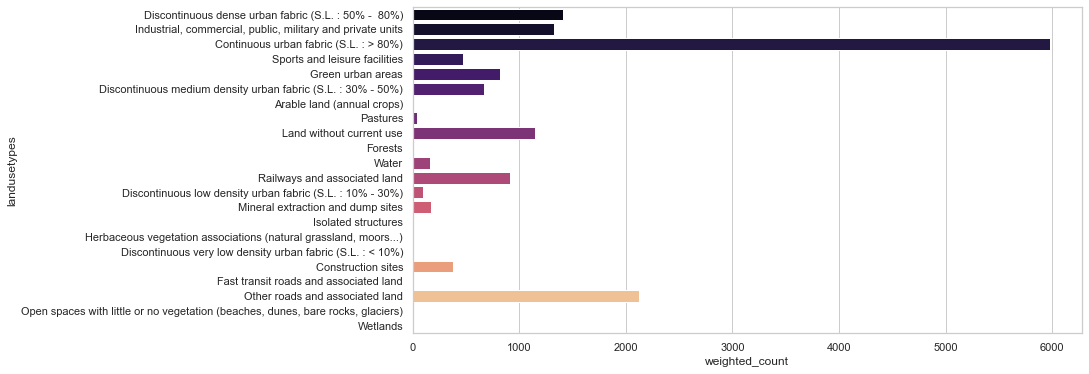

In [35]:
y1 = pd.DataFrame(columns = ["weighted_count", "landusetypes"])

y1["landusetypes"] = landusejson
for i in range(22):
    y1["weighted_count"][y1.index == i] = lastuseweighted["land_use_" + str(i+1)].sum()
y1.sort_values(["weighted_count"], ascending = False)
f, ax = plt.subplots(1,1, figsize=(12, 6))
g = sns.barplot(data = y1, x = "weighted_count", y = y1.landusetypes, palette = "magma")

The next section deals with the availability of bikes compared to land use and POIs

In [36]:
availabilityIndx = availability.reset_index()
availability9 = availabilityIndx[availabilityIndx["h3_res"] == 9]
availability9["weighted_availability"] = availability9["n_bikes"] * availability9["time_interval_length"]
hexavailability9 = availability9.groupby("hex_id")["weighted_availability"].mean()

mergedavailability9 = pd.merge(hexavailability9, pois, how='left', left_on = "hex_id", right_on = "hex")









C:\Users\jan\AppData\Local\Temp/ipykernel_2388/1600655218.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  availability9["weighted_availability"] = availability9["n_bikes"] * availability9["time_interval_length"]


In [37]:
mergedavailability9 = mergedavailability9.dropna()
mergedavailability9


,weighted_availability,hex,h3_res,hex_and_neighbors,sustenance_poi,public_transport_poi,education_poi,arts_and_culture_poi,sports_poi
16,0.004957,891f1a14493ffff,9.0,"[891f1a16267ffff, 891f1a1622bffff, 891f1a14497...",3.0,0.0,0.0,0.0,0.0
22,0.160504,891f1a144b3ffff,9.0,"[891f1a144bbffff, 891f1a14487ffff, 891f1a144b3...",1.0,4.0,0.0,0.0,0.0
39,0.000000,891f1a145b3ffff,9.0,"[891f1a145b7ffff, 891f1a145b3ffff, 891f1a145a3...",0.0,2.0,0.0,0.0,0.0
50,0.311227,891f1a16007ffff,9.0,"[891f1a16003ffff, 891f1a1603bffff, 891f1a16007...",4.0,3.0,0.0,0.0,0.0
51,4.985531,891f1a1600bffff,9.0,"[891f1a16003ffff, 891f1a16073ffff, 891f1a1600b...",24.0,10.0,1.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...
1426,0.000000,891f1abb633ffff,9.0,"[891f1abb63bffff, 891f1abb6afffff, 891f1abb623...",4.0,7.0,0.0,0.0,1.0
1427,0.056270,891f1abb63bffff,9.0,"[891f1abb63bffff, 891f1abb60fffff, 891f1abb623...",2.0,14.0,0.0,0.0,0.0
1431,0.048165,891f1abb657ffff,9.0,"[891f1abb60bffff, 891f1abb61bffff, 891f1abb653...",0.0,12.0,0.0,0.0,0.0
1437,0.002211,891f1abb68fffff,9.0,"[891f1abb613ffff, 891f1abb6bbffff, 891f1abb687...",1.0,2.0,0.0,0.0,0.0


In [38]:
cleanavailability9 = mergedavailability9.copy()
availabilityperpoi = pd.DataFrame()
for poi in poicategories:
    v = cleanavailability9.groupby(poi)["weighted_availability"].mean().to_frame(poi)
    availabilityperpoi =  pd.merge(availabilityperpoi, v, how='outer', left_index = True, right_index = True)

availabilityperpoi

,sustenance_poi,public_transport_poi,education_poi,arts_and_culture_poi,sports_poi
0.0,0.077778,0.474928,0.589642,0.850365,0.708564
1.0,0.210496,0.238165,1.067546,1.819997,1.717909
2.0,0.386999,0.234606,1.736345,3.098767,2.610365
3.0,0.375300,0.101046,1.977893,3.342821,2.593166
4.0,0.715002,0.365998,2.658063,1.878630,3.172813
...,...,...,...,...,...
125.0,3.611468,NaN,NaN,NaN,NaN
138.0,2.246249,NaN,NaN,NaN,NaN
152.0,9.196275,NaN,NaN,NaN,NaN
161.0,3.547964,NaN,NaN,NaN,NaN


The following charts show regplots that show the availability of bicycles in areas with different amounts of POIs

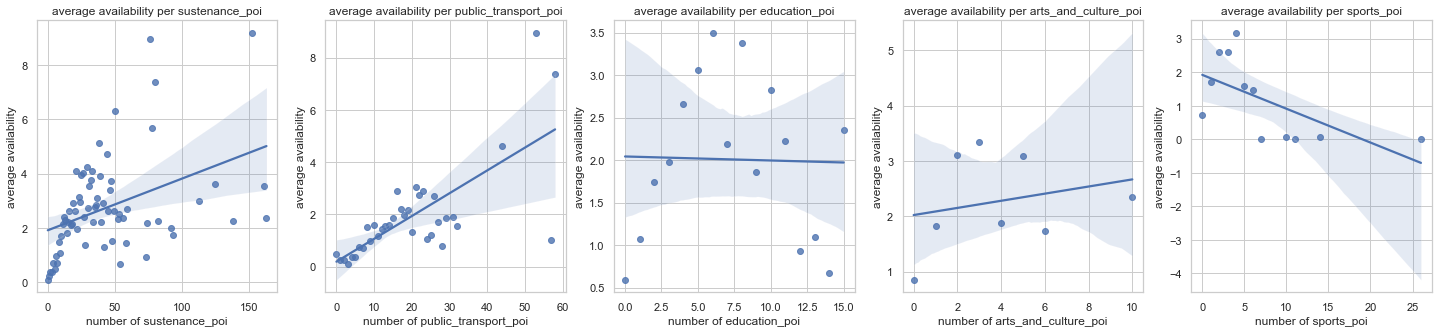

In [48]:
f, ax = plt.subplots(1, 5, figsize=(25, 5))


n = 0
for poi in poicategories:
    g = sns.regplot(data=availabilityperpoi, x=availabilityperpoi.index, y=poi, ax=ax[n])
    ax[n].set_title("average availability per " + poi)
    ax[n].set_xlabel("number of " + poi)
    ax[n].set_ylabel("average availability")
    n = n + 1
    
    


The most intersting plots are those showing the availability for the sustenance and public transport POIs

The following regplots show the availability of bikes in hexagons with different ratios of a certain land use

In [41]:
availabilityXuse = pd.merge(hexavailability9, landuse, how='left', left_on = hexavailability9.index , right_on = "hexagon_id")
availabilityXuse = availabilityXuse.dropna()


In [42]:
availabilityXuseN0 =availabilityXuse[availabilityXuse.weighted_availability != 0]
availabilityXuseN0

,hexagon_id,weighted_availability,land_use_1,land_use_2,land_use_3,land_use_4,land_use_5,land_use_6,land_use_7,land_use_8,...,land_use_13,land_use_14,land_use_15,land_use_16,land_use_17,land_use_18,land_use_19,land_use_20,land_use_21,land_use_22
4,891f1a1440fffff,0.000871,0.000000,0.000000,0.00000,0.000763,0.000000,0.000000,0.538879,0.242970,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.022325,0.0,0.0
6,891f1a1442bffff,0.072414,0.099578,0.092742,0.00000,0.000000,0.163609,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.028335,0.0,0.0
7,891f1a1442fffff,0.006900,0.126800,0.414096,0.00000,0.000000,0.007510,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.048390,0.0,0.0
8,891f1a14433ffff,0.091238,0.421781,0.084261,0.00000,0.000000,0.002329,0.313676,0.028778,0.048038,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.101136,0.0,0.0
9,891f1a1443bffff,0.011857,0.096226,0.149416,0.00000,0.155961,0.218374,0.106650,0.008899,0.216012,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.048462,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1432,891f1abb65bffff,0.052184,0.167775,0.268877,0.00000,0.000000,0.000000,0.000000,0.000000,0.379201,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.094910,0.0,0.0
1433,891f1abb66bffff,0.000067,0.000000,0.428611,0.00000,0.000000,0.000000,0.000000,0.000000,0.001003,...,0.000000,0.0,0.0,0.159594,0.0,0.0,0.000000,0.011099,0.0,0.0
1435,891f1abb67bffff,0.004421,0.000000,0.017175,0.00000,0.000000,0.000000,0.000000,0.062333,0.335078,...,0.000000,0.0,0.0,0.083427,0.0,0.0,0.000000,0.202745,0.0,0.0
1438,891f1abb6abffff,0.002814,0.000000,0.637431,0.00000,0.000000,0.000000,0.000000,0.000000,0.288256,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.016356,0.057957,0.0,0.0


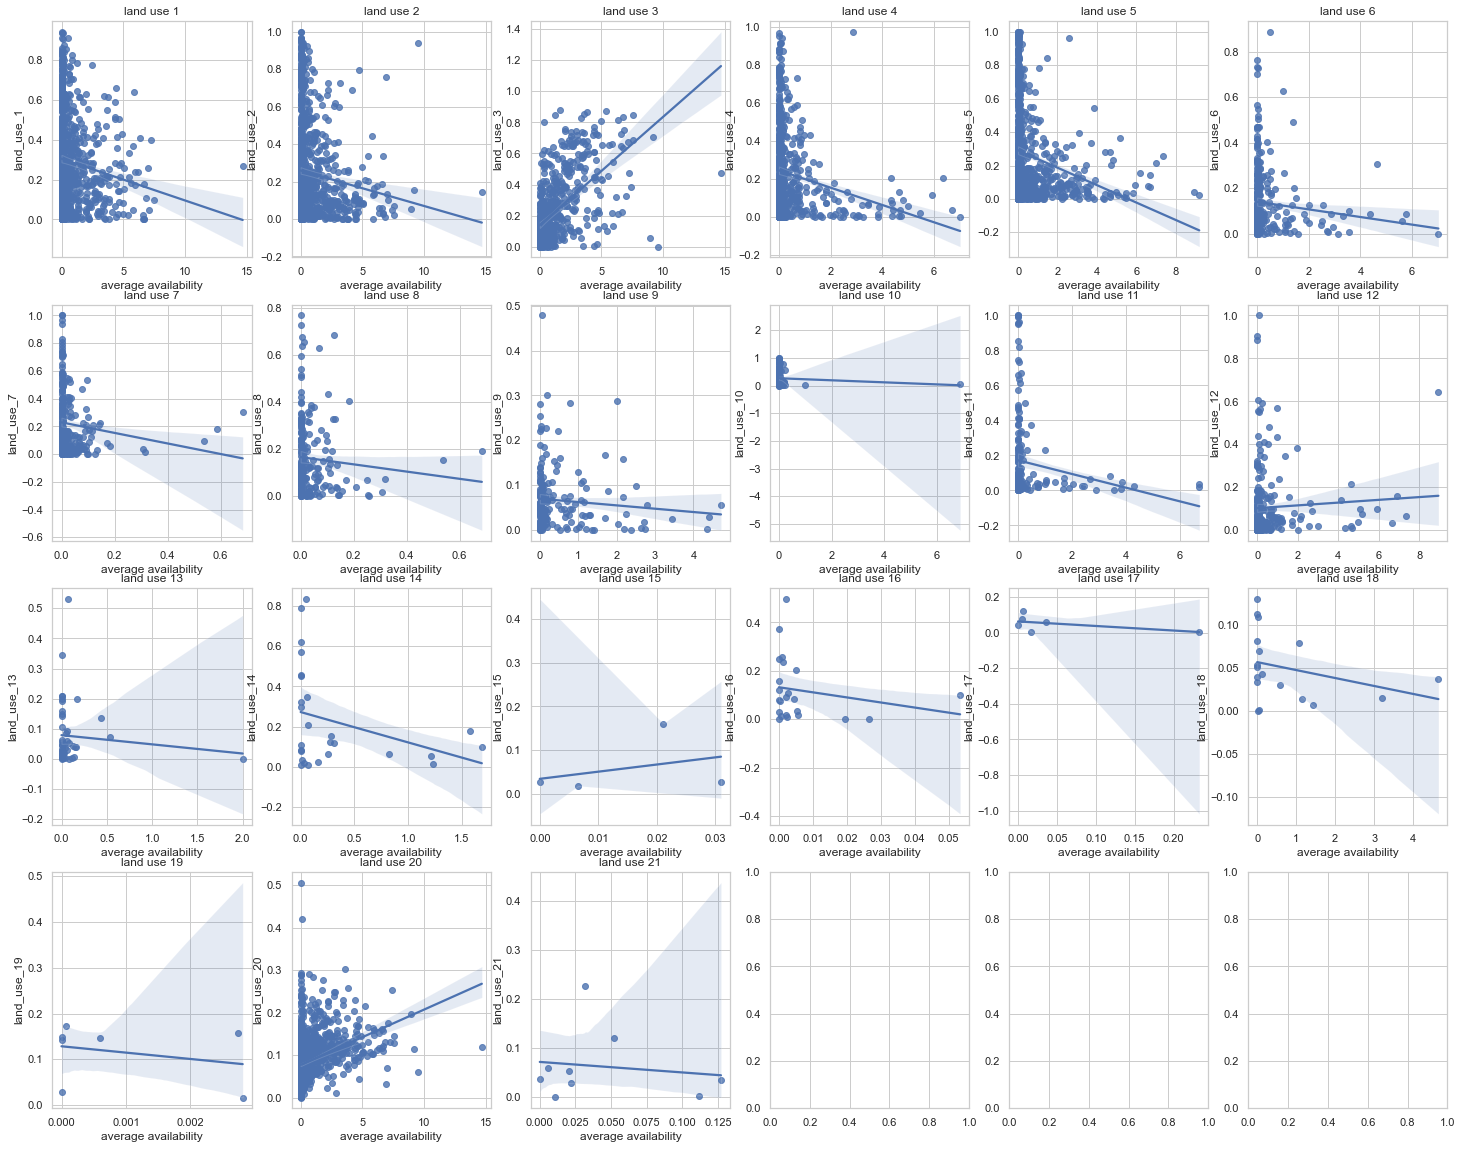

In [43]:
f, ax = plt.subplots(4,6, figsize=(25, 20))
n = range(21)
for i in n:
    g = sns.regplot(data=availabilityXuse, x=availabilityXuse.weighted_availability[availabilityXuse["land_use_" + str(i + 1)] > 0], y=availabilityXuse["land_use_" + str(i + 1)][availabilityXuse["land_use_" + str(i + 1)] > 0], ax=ax[math.floor(i/6)][i - math.floor(i/6) * 6])
    ax[math.floor(i/6)][i - math.floor(i/6) * 6].set_title("land use " + str(i + 1))
    ax[math.floor(i/6)][i - math.floor(i/6) * 6].set_xlabel("average availability")



The most intresting plots are for land uses are "continuous urban fabric" (3), "green urban areas" (5) and "other roads and associated lands" (20). That is a similar result to the analysis of trips per land use as land use three and 20  are again important.